In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
import collections
import ipynb.fs.full.Structural_Perturbations
tf.logging.set_verbosity(tf.logging.ERROR)

In [4]:
mnist = tf.contrib.learn.datasets.load_dataset("mnist")
train_data = mnist.train.images  # Returns np.array
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
eval_data = mnist.test.images  # Returns np.array
eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)

Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz


In [15]:
eval_data = Exposure(eval_data,60)

In [ ]:
eval_data = Translation(eval_data,2)

In [ ]:
eval_data = Rotation(eval_data,30)

In [34]:
eval_data = Scaling(eval_data,1.5)

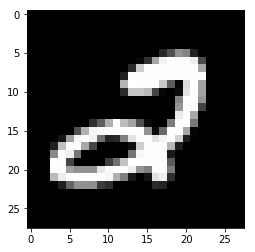

In [5]:
Display(eval_data,8889)

In [17]:
def cnn_model_fn(features, labels, mode):
  """Model function for CNN."""
  # Input Layer
  # Reshape X to 4-D tensor: [batch_size, width, height, channels]
  # MNIST images are 28x28 pixels, and have one color channel
  input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])
  print("_THIS_",type(features))
  # Convolutional Layer #1
  # Computes 32 features using a 5x5 filter with ReLU activation.
  # Padding is added to preserve width and height.
  # Input Tensor Shape: [batch_size, 28, 28, 1]
  # Output Tensor Shape: [batch_size, 28, 28, 32]
  conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=32,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

  # Pooling Layer #1
  # First max pooling layer with a 2x2 filter and stride of 2
  # Input Tensor Shape: [batch_size, 28, 28, 32]
  # Output Tensor Shape: [batch_size, 14, 14, 32]
  pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

  # Convolutional Layer #2
  # Computes 64 features using a 5x5 filter.
  # Padding is added to preserve width and height.
  # Input Tensor Shape: [batch_size, 14, 14, 32]
  # Output Tensor Shape: [batch_size, 14, 14, 64]
  conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=64,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

  # Pooling Layer #2
  # Second max pooling layer with a 2x2 filter and stride of 2
  # Input Tensor Shape: [batch_size, 14, 14, 64]
  # Output Tensor Shape: [batch_size, 7, 7, 64]
  pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

  # Flatten tensor into a batch of vectors
  # Input Tensor Shape: [batch_size, 7, 7, 64]
  # Output Tensor Shape: [batch_size, 7 * 7 * 64]
  pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])

  # Dense Layer
  # Densely connected layer with 1024 neurons
  # Input Tensor Shape: [batch_size, 7 * 7 * 64]
  # Output Tensor Shape: [batch_size, 1024]
  dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)

  # Add dropout operation; 0.6 probability that element will be kept
  dropout = tf.layers.dropout(
      inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

  # Logits layer
  # Input Tensor Shape: [batch_size, 1024]
  # Output Tensor Shape: [batch_size, 10]
  logits = tf.layers.dense(inputs=dropout, units=10)

  predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      "classes": tf.argmax(input=logits, axis=1),
      # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
      # `logging_hook`.
      "probabilities": tf.nn.softmax(logits/temprature, name="softmax_tensor")
  }
  if mode == tf.estimator.ModeKeys.PREDICT:
    return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

  # Calculate Loss (for both TRAIN and EVAL modes)
  loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

  # Configure the Training Op (for TRAIN mode)
  if mode == tf.estimator.ModeKeys.TRAIN:
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
    train_op = optimizer.minimize(
        loss=loss,
        global_step=tf.train.get_global_step())
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

  # Add evaluation metrics (for EVAL mode)
  eval_metric_ops = {
      "accuracy": tf.metrics.accuracy(
          labels=labels, predictions=predictions["classes"]),
  }
  return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [18]:
#cross entropy between two logits with temperature applied
#returns a 1d array with loss for each row in the inputs
def cross_entropy2(tar_soft_t, pred_logits_t):
   pred_soft = tf.nn.softmax(pred_logits_t)
   pred_log = tf.log(pred_soft)
   product = -1 * tar_soft_t * pred_log
   return tf.reduce_mean(product)
    
def custom_loss(y_true, pred_logits, tar_soft_t, pred_logits_t):
#    print(tf.losses.sparse_softmax_cross_entropy(labels = y_true, logits = pred_logits))
#    print(l * cross_entropy2(tar_soft_t, pred_logits_t))
   return loss_weight * tf.losses.sparse_softmax_cross_entropy(labels = y_true, logits = pred_logits) + (1-loss_weight) * cross_entropy2(tar_soft_t, pred_logits_t)

In [19]:

def student_model_fn(features, labels, mode):

  input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])
  
  conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=8,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

  # Pooling Layer #1
  # First max pooling layer with a 2x2 filter and stride of 2
  # Input Tensor Shape: [batch_size, 28, 28, 32]
  # Output Tensor Shape: [batch_size, 14, 14, 32]
  pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

  # Convolutional Layer #2
  # Computes 64 features using a 5x5 filter.
  # Padding is added to preserve width and height.
  # Input Tensor Shape: [batch_size, 14, 14, 32]
  # Output Tensor Shape: [batch_size, 14, 14, 64]
  conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=8,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

  # Pooling Layer #2
  # Second max pooling layer with a 2x2 filter and stride of 2
  # Input Tensor Shape: [batch_size, 14, 14, 64]
  # Output Tensor Shape: [batch_size, 7, 7, 64]
  pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

  # Flatten tensor into a batch of vectors
  # Input Tensor Shape: [batch_size, 7, 7, 64]
  # Output Tensor Shape: [batch_size, 7 * 7 * 64]
  pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 8])

  # Dense Layer
  # Densely connected layer with 1024 neurons
  # Input Tensor Shape: [batch_size, 7 * 7 * 64]
  # Output Tensor Shape: [batch_size, 1024]
  dense = tf.layers.dense(inputs=pool2_flat, units=256, activation=tf.nn.relu)

  # Add dropout operation; 0.6 probability that element will be kept
  dropout = tf.layers.dropout(
      inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

  # Logits layer
  # Input Tensor Shape: [batch_size, 1024]
  # Output Tensor Shape: [batch_size, 10]
  logits = tf.layers.dense(inputs=dropout, units=10)

  predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      "classes": tf.argmax(input=logits, axis=1),
      # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
      # `logging_hook`.
      "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
  }
  if mode == tf.estimator.ModeKeys.PREDICT:
    return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

  if mode == tf.estimator.ModeKeys.TRAIN:
    pred_logits_t=tf.nn.softmax(logits/temprature, name="softmax_tensor")
#     print('a',labels,'b', logits,'c', teacher_soft_t ,'d', pred_logits_t)
    loss=custom_loss(labels, logits,teacher_soft_t , pred_logits_t)
  else:
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
  
    
  # Configure the Training Op (for TRAIN mode)
  if mode == tf.estimator.ModeKeys.TRAIN:
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
    train_op = optimizer.minimize(
        loss=loss,
        global_step=tf.train.get_global_step())
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

  # Add evaluation metrics (for EVAL mode)
  eval_metric_ops = {
      "accuracy": tf.metrics.accuracy(
          labels=labels, predictions=predictions["classes"]),
  }
  return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)




In [20]:
temprature=10
loss_weight=0.75

# mnist_classifier = tf.estimator.Estimator(
#   model_fn=cnn_model_fn, model_dir="./models/mnist_convnet_model_test1")

# Create the Estimator
student_classifier = tf.estimator.Estimator(
  model_fn=student_model_fn, model_dir="./models/mnist_convnet_student_10_0.75")

# Train the model
# train_input_fn = tf.estimator.inputs.numpy_input_fn(
#   x={"x": train_data},
#   y=train_labels,
#   batch_size=100,
#   num_epochs=None,
#   shuffle=True)
# print(train_data,train_labels,eval_data,eval_labels)

# student_classifier.train(
#   input_fn=train_input_fn,
#   steps=20000,
#   hooks=None)
# print("eva",type(eval_data))

# Evaluate the model and print results
# eval_input_fn = tf.estimator.inputs.numpy_input_fn(
#   x={"x": eval_data},
#   y=eval_labels,
#   num_epochs=1,
#   shuffle=False)
# eval_result=student_classifier.evaluate(input_fn=eval_input_fn)
# # output=list(predictions)
# print(eval_result)

In [36]:
Test(train_data,train_labels,eval_data,eval_labels,student_classifier)

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.9497455, 'loss': 0.17251603, 'global_step': 20001}
######### Test accuracy #############
 {'accuracy': 0.6765, 'loss': 1.4155765, 'global_step': 20001}


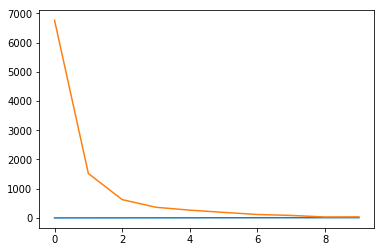

In [37]:
Plot(eval_data,eval_labels,student_classifier)